In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: good guesses for planets' mean periods

In [4]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

### define timestep dt, start/end times of integration

In [5]:
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt) # jaxttv class

### set observed transit times and errors (necessary to obtain model transit times)

In [6]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=True)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help

initial objective function: 5448.23 (53 data)

running optimization...
objective function: 50.21 (53 data)
# elapsed time (least square): 1.4 sec


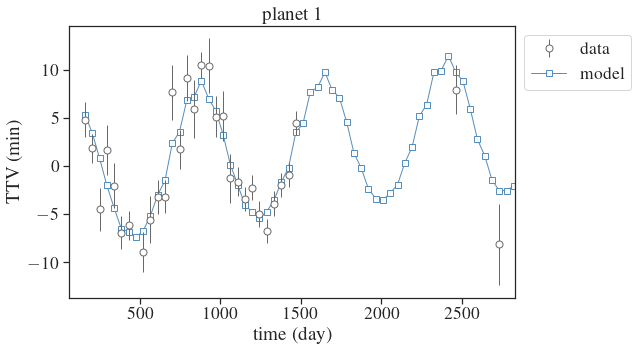

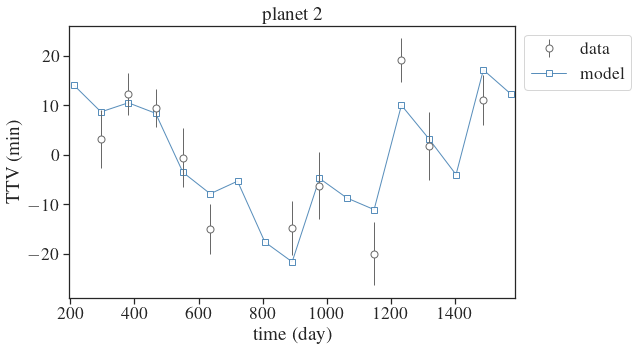

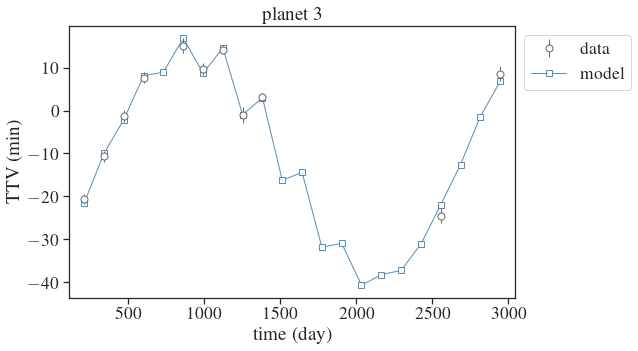

In [7]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)

In [8]:
elements, masses = params_to_elements(params_best, jttv.nplanet)
pdic = pd.DataFrame(elements_to_pdic(elements, masses))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  2.571991   45.154003 -0.021177 -0.029450   0.0   -0.0  159.110553   
1  4.054968   85.314028  0.015834 -0.004341   0.0   -0.0  295.320951   
2  5.228739  130.183979  0.009119 -0.003446   0.0    0.0  212.023436   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.036274 -2.194223 -11.771055  0.000008 -0.583821 -0.811883  
1  0.016418 -0.267559 -11.315793  0.000012  0.964419 -0.264378  
2  0.009749 -0.361254 -11.061566  0.000016  0.911929 -0.344559  


### check precision of transit times

In [9]:
%%time
tc, tc_precise = jttv.check_timing_precision(params_best)

# fractional energy error (symplectic, dt=1.00e+00): 3.16e-09
# fractional energy error (Hermite4, dt=4.52e-02): -5.20e-12
# max difference in tc: 6.01e-06 days (0.52 sec)
CPU times: user 1.39 s, sys: 95.3 ms, total: 1.48 s
Wall time: 1.38 s


In [10]:
%%time
_, tc_precise_sym = jttv.check_timing_precision(params_best, symplectic=True)

# fractional energy error (symplectic, dt=1.00e+00): 3.16e-09
# fractional energy error (symplectic, dt=4.52e-02): 6.45e-12
# max difference in tc: 6.11e-06 days (0.53 sec)
CPU times: user 3.37 s, sys: 103 ms, total: 3.47 s
Wall time: 3.31 s


### check the distribution of residuals

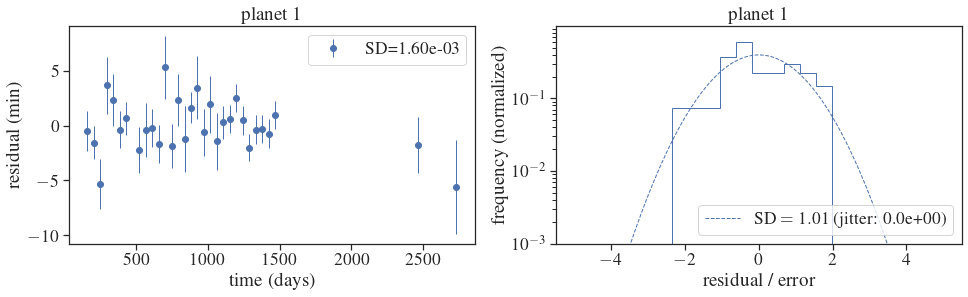

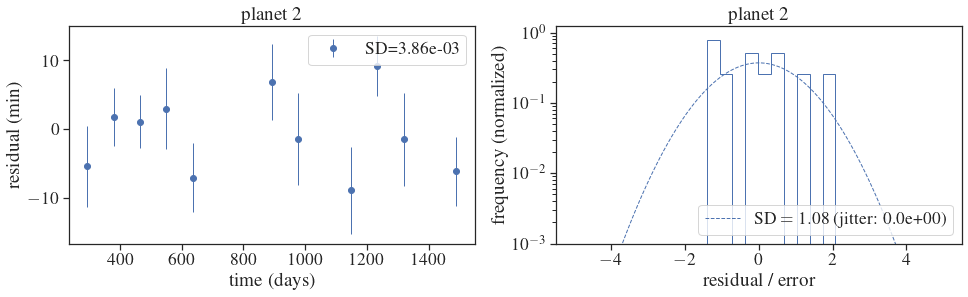

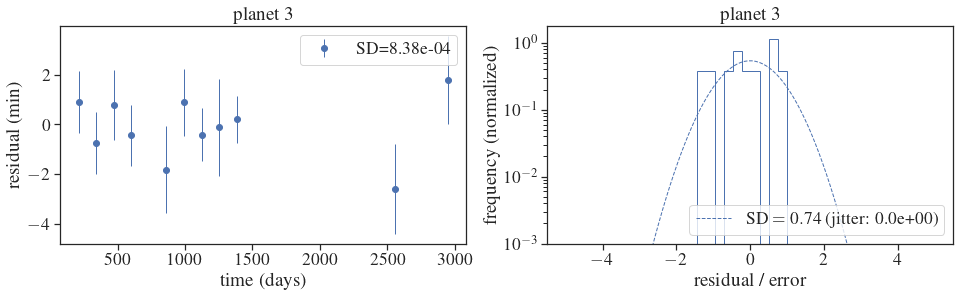

In [11]:
jttv.check_residuals(tc)

In [38]:
from jax import grad, jit
func = lambda elements, masses: jnp.sum(jttv.get_ttvs(elements, masses)[0])
gfunc = jit(grad(func, argnums=(0,1,)))
%timeit jttv.get_ttvs(elements, masses)

2.37 ms ± 61.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%timeit jac_best = gfunc(elements, masses)

17.9 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### initialize HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [12]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

def model(dp=5e-1, dtic=1e-1, emax=0.3, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))
    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))
    lnode = numpyro.deterministic("lnode", ones*0)
    cosi = numpyro.deterministic("cosi", ones*0)
    
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = numpyro.deterministic("mass", jnp.exp(lnmass))

    elements = numpyro.deterministic("elements", jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T)
    masses = numpyro.deterministic("masses", jnp.hstack([1., mass]))

    tcmodel, ediff = jttv.get_ttvs(elements, masses)
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
        
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [13]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

In [14]:
pdic_init

{'period': DeviceArray([ 45.15400322,  85.31402842, 130.18397873], dtype=float64),
 'cosi': DeviceArray([0., 0., 0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.,  0.], dtype=float64),
 'tic': DeviceArray([159.11055344, 295.32095114, 212.02343566], dtype=float64),
 'ecc': DeviceArray([0.03627368, 0.01641781, 0.00974852], dtype=float64),
 'lnmass': DeviceArray([-11.77105535, -11.31579311, -11.06156579], dtype=float64),
 'mass': DeviceArray([7.72494892e-06, 1.21790522e-05, 1.57044603e-05], dtype=float64),
 'cosw': DeviceArray([-0.58382059,  0.96441913,  0.9119293 ], dtype=float64),
 'sinw': DeviceArray([-0.8118827 , -0.26437803, -0.34455853], dtype=float64)}

In [15]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)#, forward_mode_differentiation=True)

In [16]:
nw, ns, linm, tcjitter = 100, 100, True, None  # 2hr -> 40min
nw, ns, linm, tcjitter = 500, 1000, True, None # 13.5hr (new) -> 5hr!

In [17]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [18]:
output = "kep51/dt%.1f_"%jttv.dt
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [19]:
output

'kep51/dt1.0_nw500_ns1000_'

In [20]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

kep51/dt1.0_nw500_ns1000_mcmc.pkl loaded.


In [21]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.71      0.39     -0.69     -1.25     -0.08     47.30      1.01
   cosw[1]      0.51      0.87      0.47     -0.89      1.92     44.84      1.15
   cosw[2]     -0.10      1.08     -0.07     -1.69      1.84     22.59      1.12
    ecc[0]      0.03      0.01      0.03      0.01      0.04     28.26      1.00
    ecc[1]      0.01      0.01      0.01      0.00      0.02     23.02      1.04
    ecc[2]      0.01      0.01      0.01      0.00      0.02     27.03      1.01
   mass[0]      0.00      0.00      0.00      0.00      0.00     28.65      1.02
   mass[1]      0.00      0.00      0.00      0.00      0.00     33.01      1.01
   mass[2]      0.00      0.00      0.00      0.00      0.00     32.60      1.03
 period[0]     45.15      0.00     45.15     45.15     45.15     48.26      1.04
 period[1]     85.31      0.00     85.31     85.31     85.32     24.84      1.01
 period[2]    130.18      0

In [22]:
samples = mcmc.get_samples()

In [23]:
means, stds = jttv.sample_means_and_stds(samples)

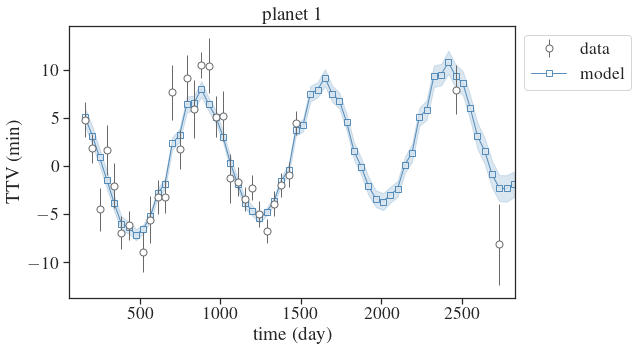

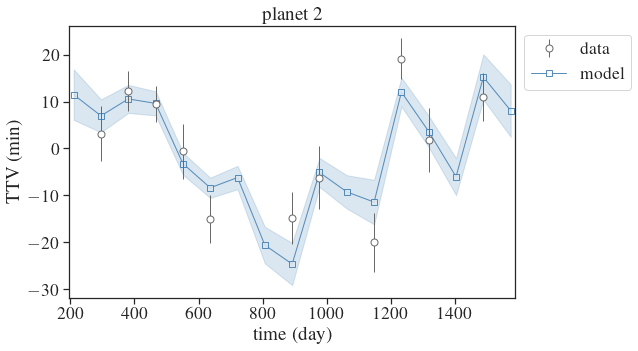

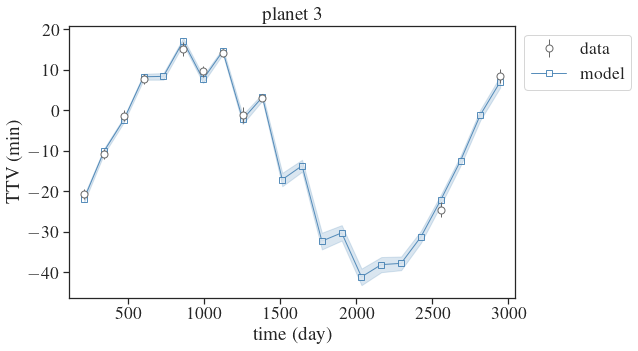

In [26]:
t0_lin, p_lin = jttv.linear_ephemeris()
plot_model(means, jttv.tcobs, jttv.errorobs, t0_lin, p_lin, tcmodelunclist=stds)

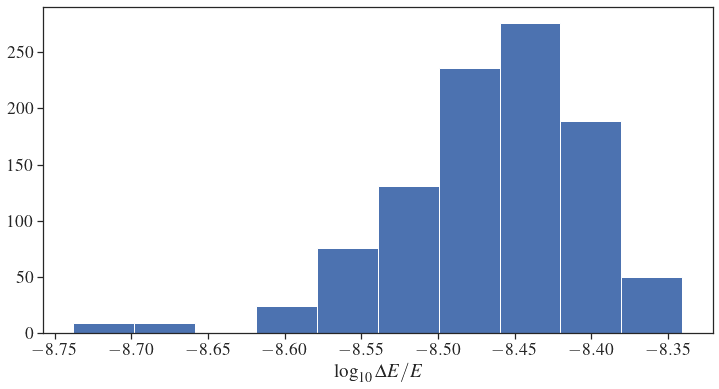

In [35]:
plt.xlabel("$\log_{10} (\Delta E/E)$")
plt.hist(np.log10(np.abs(samples['ediff'])));

In [33]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

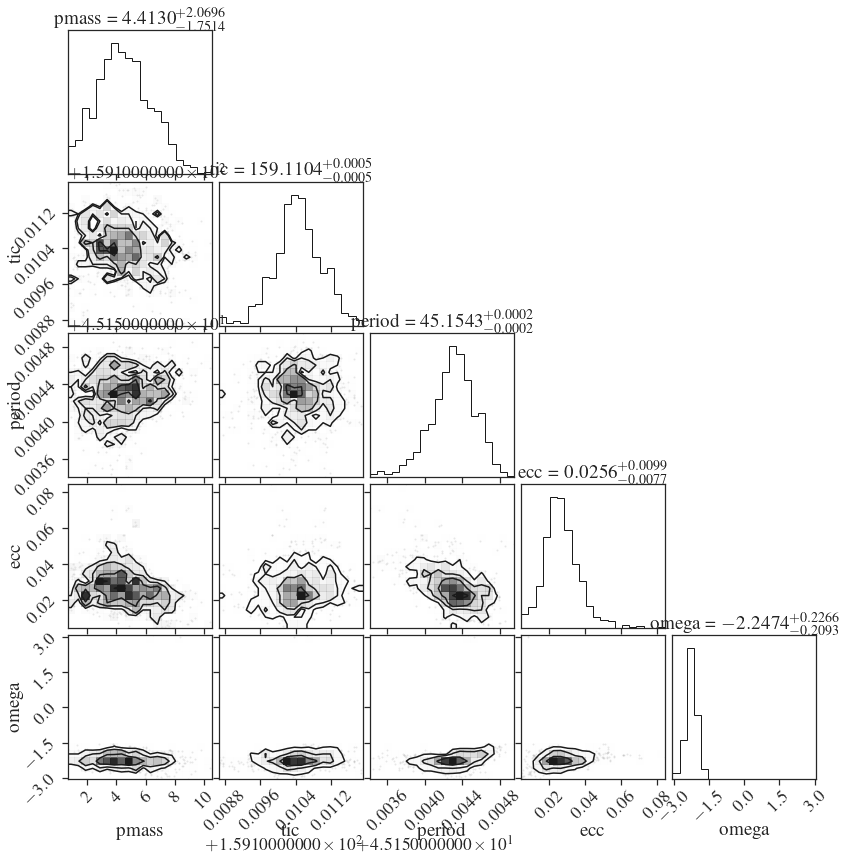

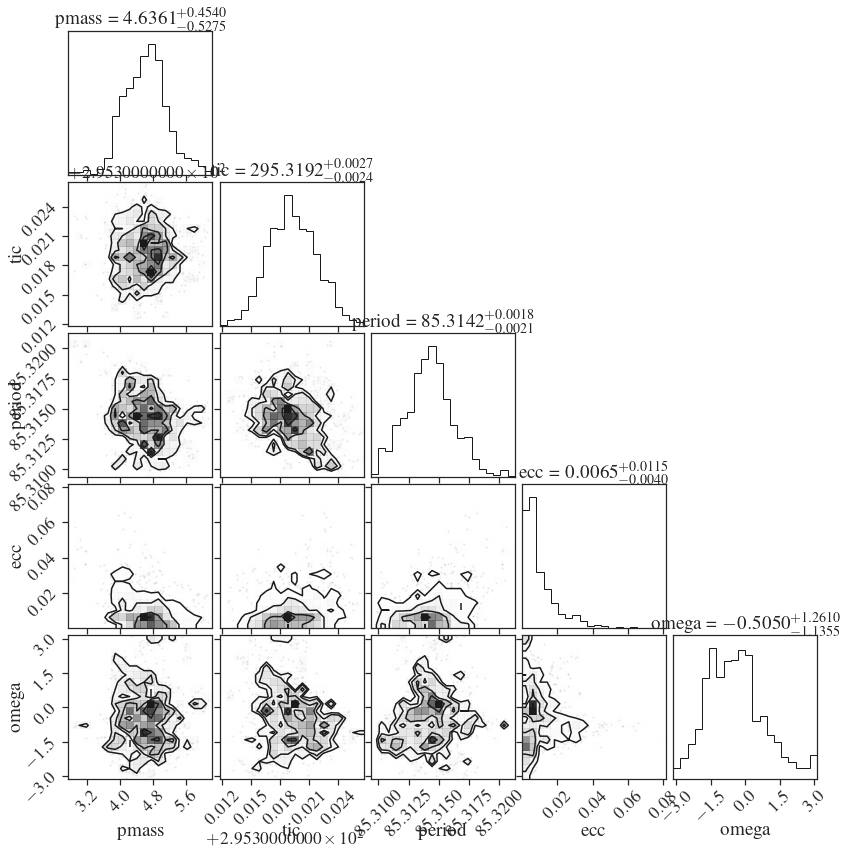

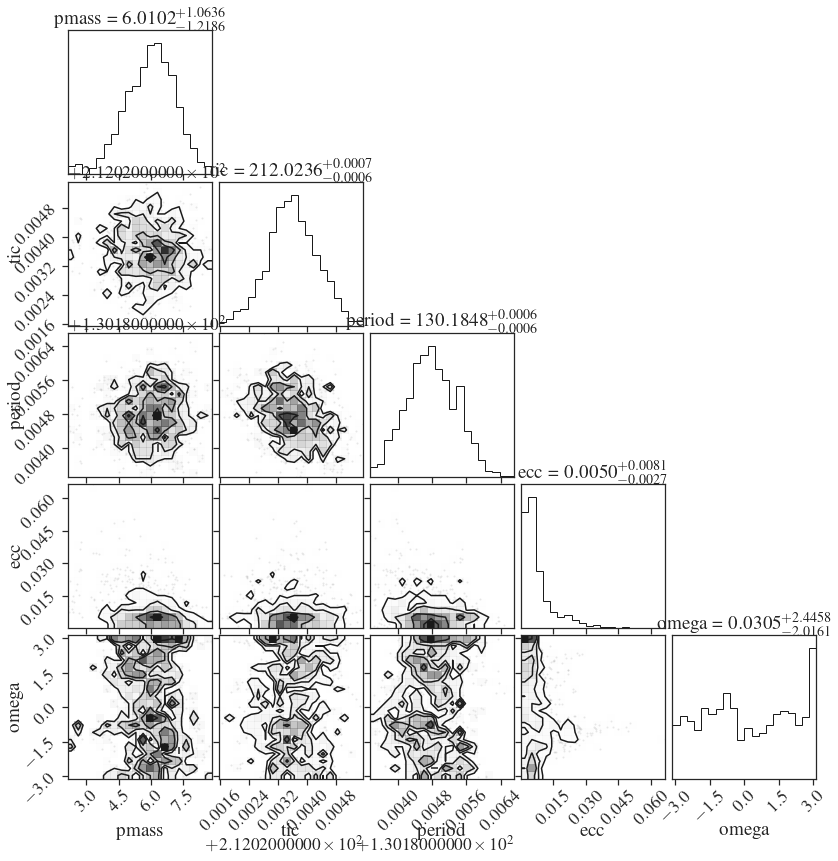

In [34]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    #plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");